In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import os

In [1]:

# Define directories
image_dir = "D:\\random\\sat\\image\\"
mask_dir = "D:\\random\\sat\\mask\\"

# Parameters image has been converted to 256 to 256 resolution 
img_size = (256, 256)

# Load images from directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
    return images

# Load images and masks
images = load_images_from_folder(image_dir)
masks = load_images_from_folder(mask_dir)

# Convert to numpy arrays and normalize
images = np.array(images) / 256.0
masks = np.array(masks) / 256.0

# Convert masks to grayscale if they are not
if masks.shape[-1] == 3:
    masks = np.mean(masks, axis=-1, keepdims=True)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = unet_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [3]:
# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10, 
                    batch_size=8)

Epoch 1/10
234/234 [==============================] - 3330s 14s/step - loss: 0.4876 - accuracy: 0.9544 - val_loss: 0.1565 - val_accuracy: 0.9510
Epoch 2/10
234/234 [==============================] - 3125s 13s/step - loss: 0.1454 - accuracy: 0.9544 - val_loss: 0.1501 - val_accuracy: 0.9510
Epoch 3/10
234/234 [==============================] - 2963s 13s/step - loss: 0.1436 - accuracy: 0.9544 - val_loss: 0.1475 - val_accuracy: 0.9510
Epoch 4/10
234/234 [==============================] - 2972s 13s/step - loss: 0.1363 - accuracy: 0.9544 - val_loss: 0.1387 - val_accuracy: 0.9506
Epoch 5/10
234/234 [==============================] - 2965s 13s/step - loss: 0.1246 - accuracy: 0.9531 - val_loss: 0.1270 - val_accuracy: 0.9486
Epoch 6/10
234/234 [==============================] - 2964s 13s/step - loss: 0.1136 - accuracy: 0.9512 - val_loss: 0.1187 - val_accuracy: 0.9474
Epoch 7/10
234/234 [==============================] - 2961s 13s/step - loss: 0.1074 - accuracy: 0.9499 - val_loss: 0.1109 - val_ac

In [47]:
#predicted from modelon validation set

1/1 [==============================] - 1s 564ms/step


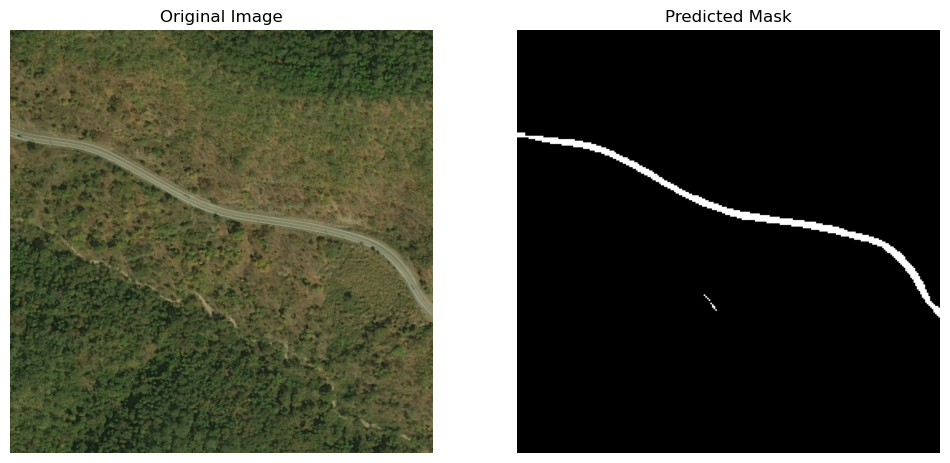

1/1 [==============================] - 1s 596ms/step


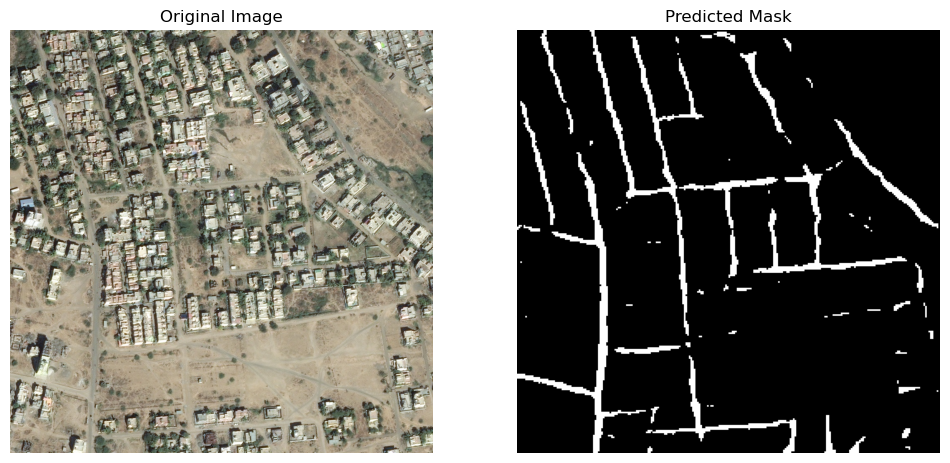

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Function to predict road networks on new images


# Function to display images using matplotlib
def display_images(original_img, predicted_mask):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    plt.show()

# Run multiple iterations
test_images = ["D:\\random\\sat\\test\\7890_sat.jpg","D:\\random\\sat\\test\\18787_sat.jpg"]  # List of test image paths
for img_path in test_images:
    original_img, predicted_mask = predict_road_network(img_path, model)
    display_images(original_img, predicted_mask)


In [48]:
# metrics Checking after model development after that we can do  hyperparameter tuning

In [8]:
from sklearn.metrics import accuracy_score, f1_score
import tensorflow.keras.backend as K

# Define IoU metric
def iou_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return intersection / union

# Define F1 score metric
def f1_metric(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    tp = K.sum(y_true_f * y_pred_f)
    predicted_positive = K.sum(y_pred_f)
    actual_positive = K.sum(y_true_f)
    precision = tp / (predicted_positive + K.epsilon())
    recall = tp / (actual_positive + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric, f1_metric])


In [10]:
# Evaluate the model
val_loss, val_accuracy, val_iou, val_f1 = model.evaluate(X_val, y_val, verbose=0)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation IoU: {val_iou}')
print(f'Validation F1 Score: {val_f1}')


Validation Loss: 0.09641701728105545
Validation Accuracy: 0.946020245552063
Validation IoU: 0.25376975536346436
Validation F1 Score: 0.40445175766944885


In [49]:
#Model Accuracy by epoch and model loss by epoch 

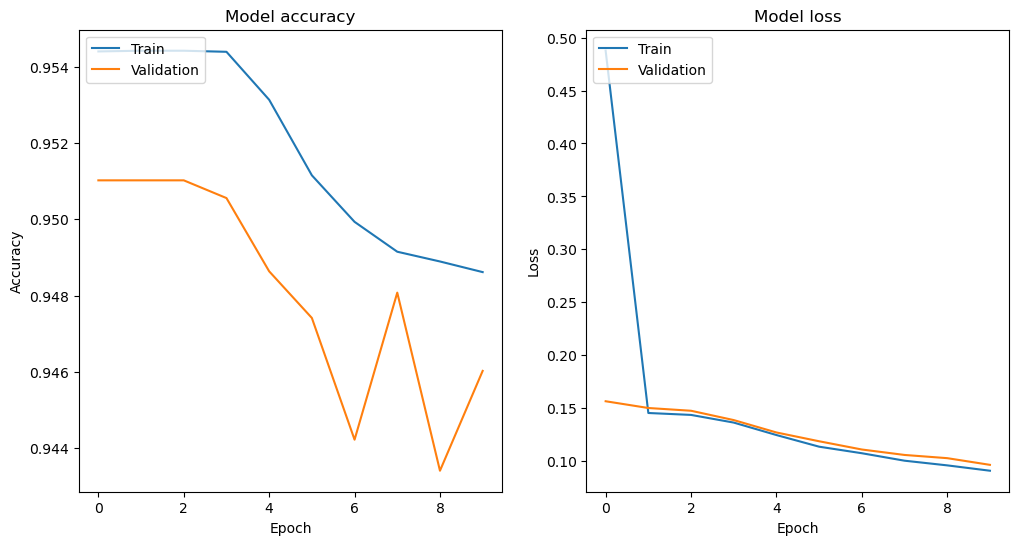

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [50]:
# Save the model in different format and can used for the deployment
model.save('unet_model.h5')
model.save('unet_model')

D:\jupyter\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: unet_model\assets


INFO:tensorflow:Assets written to: unet_model\assets
